In [101]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

In [103]:
C22F002 = pd.read_csv('C22F002.csv')

In [124]:
C22F002.plot(x="C22F002[C22F002.columns[0]],y="C22F002[C22F002.columns[1]]")


SyntaxError: invalid syntax (1659722391.py, line 1)

In [104]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

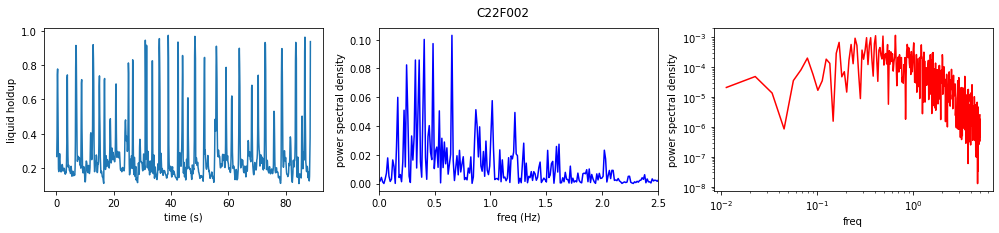

In [126]:
fig_C22F002, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F002.suptitle('C22F002')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.5])
data[2].set_xlabel('freq')
data[2].set_ylabel('power spectral density')

freqs, ps, psd = spectrum1(C22F002[C22F002.columns[1]], dt=0.1)

data[0].plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]])
#data[1].loglog(freqs,psd,'r',freqs,ps,'b')
data[1].plot(freqs,psd,'b')
data[2].loglog(freqs,ps,'r')



In [135]:
type(C22F002)

pandas.core.frame.DataFrame

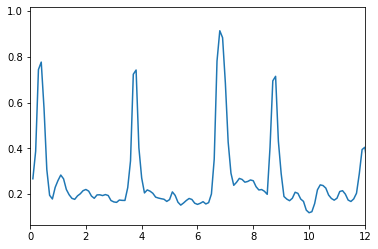

In [164]:
plt.xlim([0,12])
plt.plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]])

In [156]:
slug_signal = C22F002.iloc[:, 1]

In [157]:
print('length of signal to analyze', len(slug_signal))

max_time_delay = 200 
max_embedding_dimension = 9
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    slug_signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

length of signal to analyze 886
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8


In [168]:
embedding_dimension = 8
embedding_time_delay = 11
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [173]:
homology_dimensions = (0,1, 2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 432, 3)
y_slug_embedded.shape (432, 3)


In [174]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[8.37487246, 6.48645874, 3.72394654]])

Albeit there is very low persistence in this timeseries, the homology class H_2 has extremely low entropy. This is sign of order in the high dimensional structure.

In [145]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

embedding_dimension = 8
embedding_time_delay = 11
stride = 1

embedder = SingleTakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)


batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], n_jobs=-1)

#scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)


steps = [("embedder", embedder),
         ("pca", batch_pca),
         
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]
topological_transfomer = Pipeline(steps)

In [146]:
slug_signal_reshaped = slug_signal.reshape(1, *slug_signal.shape)
features = topological_transfomer.fit_transform(slug_signal)

AttributeError: 'Series' object has no attribute 'reshape'

In [149]:
features = topological_transfomer.fit_transform(slug_signal)

ValueError: Expected 2D array, got 1D array instead:
array=[0.26768448 0.26741506 0.18236791 0.17299805 0.1874869  0.1726987
 0.78170932 0.25582997].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.